In [126]:
import os
import importlib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score


from customer_segmentation.utils import functions

importlib.reload(functions)

# Set pandas to display all columns
pd.set_option("display.max_columns", None)

In [39]:
# import data
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, os.path.pardir, "data")
file_name = "cohort_data.csv"
file_path = os.path.join(data_dir, file_name)

cohort = pd.read_csv(file_path)

### **Preprocessing**

In [40]:
# convert data & seperate binary and numeric values

cohort["user_id"] = cohort["user_id"].astype(str)
# get binary and numeric values
binary_cols = functions.get_binary_columns(cohort)
numeric_cols = cohort.select_dtypes(include=[np.number]).columns.to_list()

**Select features for scaling & PCA**

In [85]:
feature_groups = {
    # Split discounts
    "flight_discount_score": [
        "avg_flight_discount",
        "flight_discount_rate",
        "discount_per_km",
    ],
    "hotel_discount_score": [
        "avg_hotel_discount",
        "hotel_discount_rate",
    ],

    # User demographics
    "user_score": ["age", "is_married", "has_children"],

    # Booking features
    "booking_score": ["trips_per_month"],
    "flight_booking_score": ["flight_booked"],
    "hotel_booking_score": ["hotel_booked"],

    # Engagement
    "engagement_score": [
        "days_last_trip",
        "sessions_per_month",
        "avg_session_duration_seconds",        
    ],

    # Travel features split
    "flight_travel_score": [
        "avg_flight_travel_days",
        "avg_seats",
        "avg_checked_bags",
        "avg_distance_km",
    ],
    "hotel_travel_score": [
        "avg_rooms",
        "avg_hotel_nights",
    ],
    "general_travel_score": [
        "avg_diff_trip_days",
        "avg_days_advance_booking",
        "avg_travel_days",
    ],

    # Spending
    "spending_score": ["avg_booking_value"],

    # Cancellations
    "cancellation_score": ["cancellation_rate"],
}

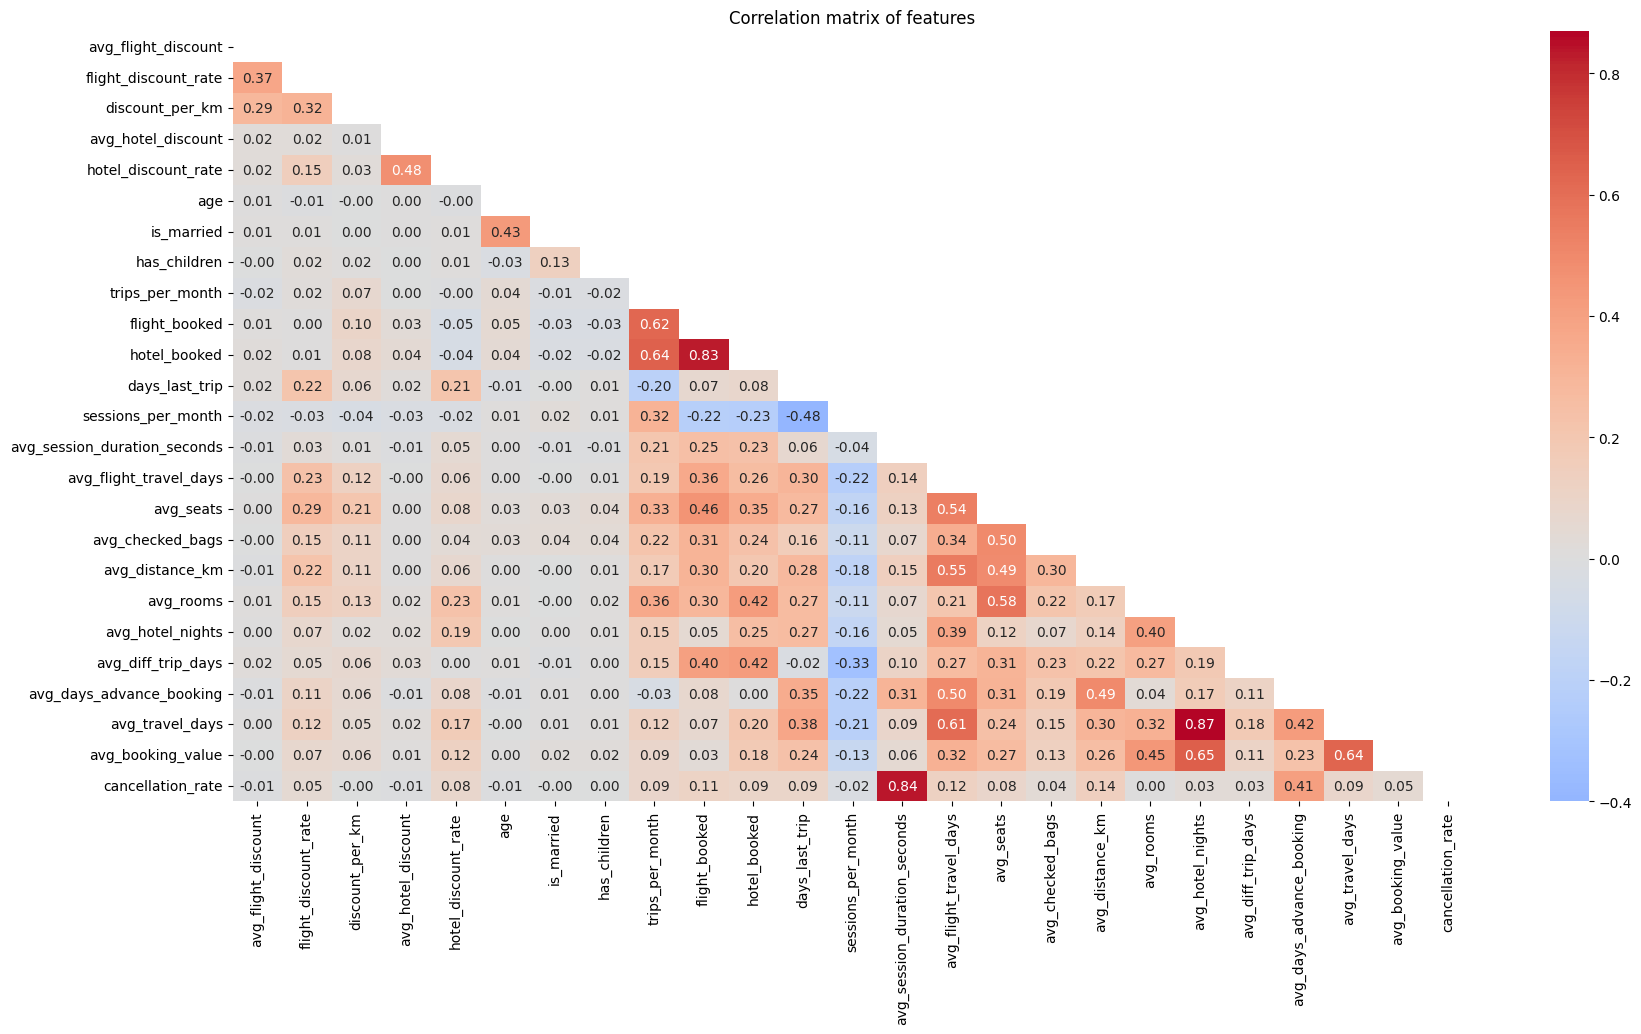

In [86]:
metrics = [m for k, metric in feature_groups.items() for m in metric]

matrix = np.triu(cohort[metrics].corr())
plt.figure(figsize=(20, 10))
plt.title('Correlation matrix of features', fontsize=12)
sns.heatmap(cohort[metrics].corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-0.4, center=0, mask=matrix)
plt.show()

**Apply PCA per thematic groups**

In [87]:
for score_name, features in feature_groups.items():
    cohort = functions.PCA_pipeline(df=cohort, features=features, score_name=score_name)


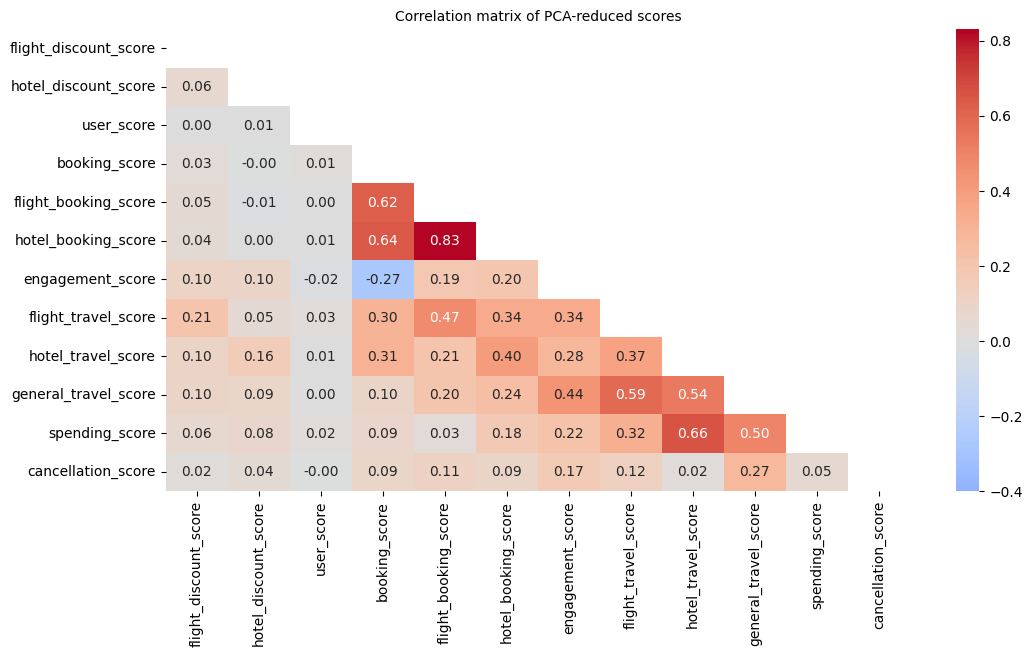

In [88]:
scores = [k for k in feature_groups.keys()]

matrix = np.triu(cohort[scores].corr())
plt.figure(figsize=(12, 6))
plt.title('Correlation matrix of PCA-reduced scores', fontsize=10)
sns.heatmap(cohort[scores].corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-0.4, center=0, mask=matrix)
plt.show()

### **Clustering**

**Extract scores for clustering**

In [89]:
X = cohort[scores]

**Apply elbow-method to find k number of cluster**

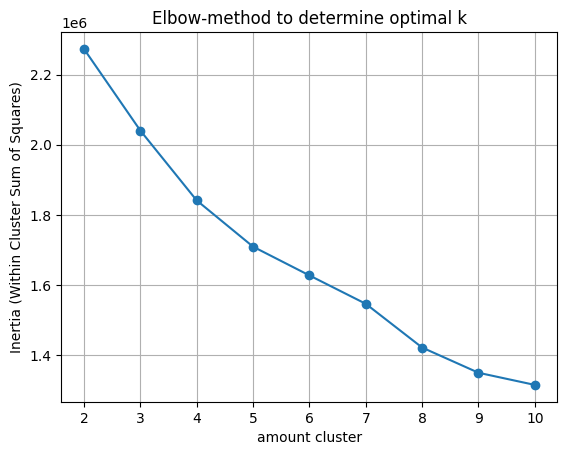

In [90]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, "o-")
plt.xlabel("amount cluster")
plt.ylabel("Inertia (Within Cluster Sum of Squares)")
plt.title("Elbow-method to determine optimal k")
plt.grid(True)
plt.show()

**Apply kmeans clustering**

In [120]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
cohort["kmeans_cluster"] = kmeans.fit_predict(X)

In [121]:
# mean values per cluster
cluster_profiles = cohort.groupby("kmeans_cluster")[scores].mean()

cluster_profiles.T.style.background_gradient(cmap="Blues")

kmeans_cluster,0,1,2,3,4
flight_discount_score,1.368886,-0.452445,0.264408,-0.771110,-0.635584
hotel_discount_score,0.324129,-0.246084,0.097471,0.737242,-0.559873
user_score,-0.022551,0.012521,0.100504,-0.024533,-0.006806
booking_score,-0.180391,0.738556,-0.532916,-0.417470,-1.195046
flight_booking_score,-0.090033,0.791743,-0.049701,-0.943173,-1.218307
hotel_booking_score,-0.144253,0.749564,-0.369269,-0.396707,-1.362854
engagement_score,0.360558,-0.115877,1.494693,0.446032,-1.204527
flight_travel_score,0.409659,0.464416,3.587286,-1.356832,-2.066222
hotel_travel_score,0.137599,0.196833,0.712486,0.977488,-1.865090
general_travel_score,-0.034715,0.030762,3.501055,0.318195,-1.460461


**GGM clustering**

In [118]:
gmm = GaussianMixture(n_components=5, random_state=42)
cohort["gmm_cluster"] = gmm.fit_predict(X)

In [119]:
# mean values per cluster
cluster_profiles = cohort.groupby("gmm_cluster")[scores].mean()

cluster_profiles.T.style.background_gradient(cmap="Blues")

gmm_cluster,0,1,2,3,4
flight_discount_score,-0.006585,0.135641,0.374345,0.236964,-0.642879
hotel_discount_score,-0.062827,0.198540,0.076882,0.329688,-0.538371
user_score,0.003890,-0.010941,0.044603,-0.008416,-0.009601
booking_score,0.544981,1.441937,-0.591823,-0.354305,-1.350248
flight_booking_score,0.683399,1.376173,-0.155302,-0.683975,-1.291829
hotel_booking_score,0.597567,1.387542,-0.555519,-0.423335,-1.412694
engagement_score,0.063097,0.668267,1.568432,0.199369,-1.263688
flight_travel_score,0.454752,0.226652,3.429323,-0.307136,-2.241997
hotel_travel_score,0.129330,0.141099,0.438103,0.566981,-1.966042
general_travel_score,0.071610,-0.042148,3.786179,0.034564,-1.553616


### **Compare cluster models**

In [ ]:
# Adjusted Rand Index (ARI) measures the similarity of two cluster assignments

ari = adjusted_rand_score(cohort["kmeans_cluster"], cohort["gmm_cluster"])
print(f"Adjusted Rand Index: {ari:.2f}")


Adjusted Rand Index: 0.43


In [127]:
# Beispiel 1: Bewertung für KMeans
labels_kmeans = cohort["kmeans_cluster"]
db_kmeans = davies_bouldin_score(X, labels_kmeans)
ch_kmeans = calinski_harabasz_score(X, labels_kmeans)

print("KMeans - Davies-Bouldin:", round(db_kmeans, 2))
print("KMeans - Calinski-Harabasz:", round(ch_kmeans, 2))

# Beispiel 2: Bewertung für Gaussian Mixture Model
labels_gmm = cohort["gmm_cluster"]
db_gmm = davies_bouldin_score(X, labels_gmm)
ch_gmm = calinski_harabasz_score(X, labels_gmm)

print("GMM - Davies-Bouldin:", round(db_gmm, 2))
print("GMM - Calinski-Harabasz:", round(ch_gmm, 2))


KMeans - Davies-Bouldin: 1.83
KMeans - Calinski-Harabasz: 27910.32
GMM - Davies-Bouldin: 1.94
GMM - Calinski-Harabasz: 22671.22


In [125]:
# Compare cluster sizes

print("Compare cluster sizes:")
print(cohort["kmeans_cluster"].value_counts(normalize=True))

print(cohort["gmm_cluster"].value_counts(normalize=True))


Compare cluster sizes:
kmeans_cluster
1    0.410948
0    0.265945
4    0.147846
3    0.126013
2    0.049247
Name: proportion, dtype: float64
gmm_cluster
0    0.524046
3    0.294265
4    0.129227
2    0.040562
1    0.011900
Name: proportion, dtype: float64


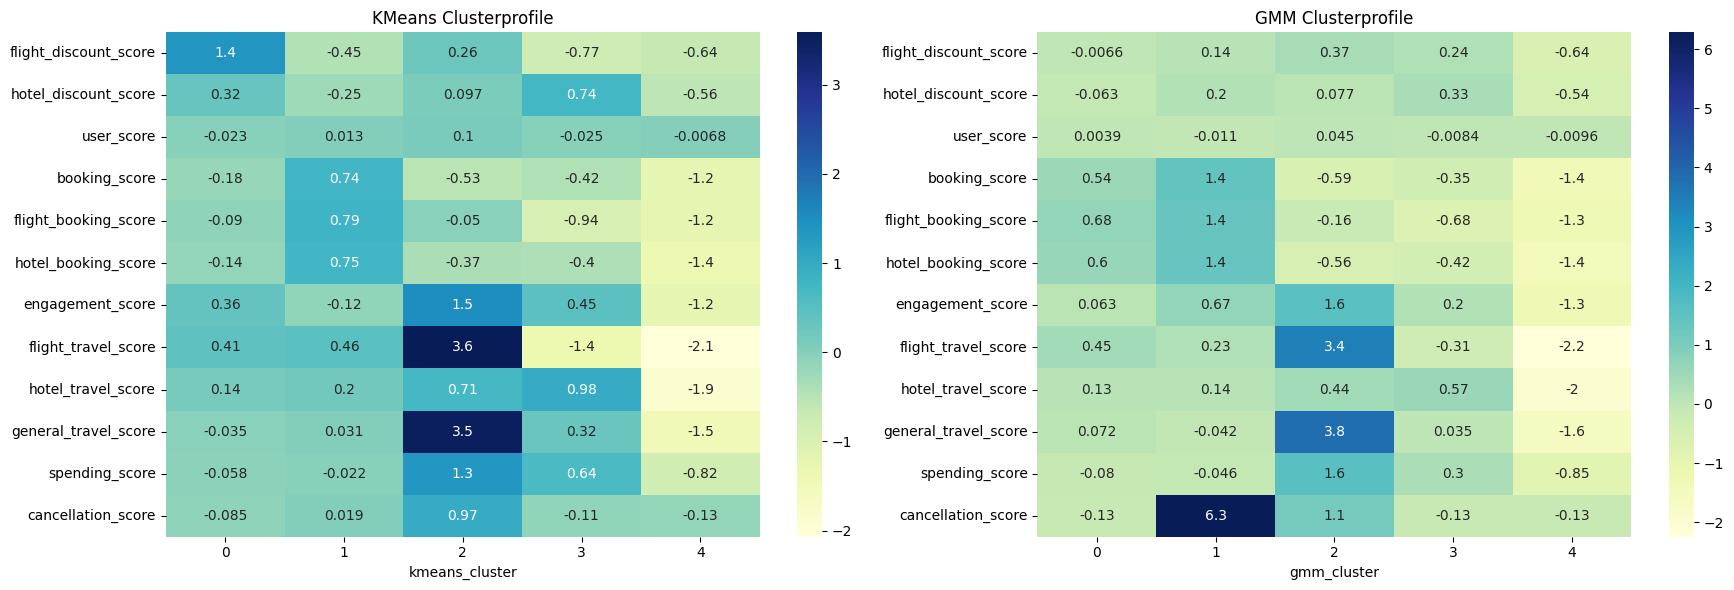

In [ ]:
# KMeans
profiles_kmeans = cohort.groupby("kmeans_cluster")[scores].mean()

# GMM
profiles_gmm = cohort.groupby("gmm_cluster")[scores].mean()


fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(profiles_kmeans.T, ax=axes[0], cmap="YlGnBu", annot=True)
axes[0].set_title("KMeans cluster profile")

sns.heatmap(profiles_gmm.T, ax=axes[1], cmap="YlGnBu", annot=True)
axes[1].set_title("GMM cluster profile")

plt.tight_layout()
plt.show()

**Conclusion**  
Kmeans performances slightly better regarding:  
davies_bouldin_score (lower value than GGM)  
calinski_harabasz_score (higher value than GGM)  
Also, mean score values are more discriminant in each cluster for the Kmeans model


### **Labeling segments based on cluster results**

In [130]:
cluster_labels = {
    0: "Flight Discount Hunter",
    1: "Package Traveller",
    2: "Frequent Flight Traveller with Cancellations",
    3: "Hotel Discount Hunter",
    4: "Churn-risk User",   
}
cohort["customer_segments"] = cohort["kmeans_cluster"].map(cluster_labels)


In [131]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, os.path.pardir, "data")
data_path = os.path.join(data_dir, "cluster_profiles.csv")
profiles_kmeans.to_csv(data_path, index=False)